<a href="https://colab.research.google.com/github/mrutherfoord/portfolio/blob/master/Boston_Housing_Data_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boston Housing Data

FOr this project I will be looking at Boston housing data in order to create models that can predict housing prices dependent on a number of variables. I will be using two types of linear regression in this project: Linear Regression (aka OLS), and Ridge Regression. I will be using all of the explanatory variables with the exception of the neighborhood name for this project.

In [0]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

SET_FIT_INTERCEPT = True

# pretty print dataframes
from IPython.display import display

# import base packages into the namespace for this program
import numpy as np
import pandas as pd

# modeling routines from Scikit Learn packages
import sklearn.linear_model 
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import cross_val_score, cross_val_predict, learning_curve, train_test_split
from math import sqrt  # for root mean-squared error calculation
from sklearn.preprocessing import StandardScaler

# ignore some warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

For the first step, I created a dataframe and took a look at the descriptive statistics.

In [0]:
# read data for the Boston Housing Study
# creating data frame restdata
boston_input = pd.read_csv('boston.csv')

# check the pandas DataFrame object boston_input
print('\nBoston DataFrame First 5 Rows:')
display (boston_input.head())

print('\nBoston DataFrame Last 5 Rows:')
display (boston_input.tail())

print('\nGeneral description of the boston_input DataFrame:')
print(boston_input.info())

# drop neighborhood from the data being considered
boston = boston_input.drop('neighborhood', 1)
print('\nGeneral description of the boston DataFrame:')
print(boston.info())

print('\nDescriptive statistics of the boston DataFrame:')
print(boston.describe())


Boston DataFrame First 5 Rows:


,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,Nahant,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,Swampscott,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,Swanpscott,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,Marblehead,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,Marblehead,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2



Boston DataFrame Last 5 Rows:


,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
501,Winthrop,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,Winthrop,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,Winthrop,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,Winthrop,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0
505,Winthrop,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273,21.0,7.88,19.0



General description of the boston_input DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
neighborhood    506 non-null object
crim            506 non-null float64
zn              506 non-null float64
indus           506 non-null float64
chas            506 non-null int64
nox             506 non-null float64
rooms           506 non-null float64
age             506 non-null float64
dis             506 non-null float64
rad             506 non-null int64
tax             506 non-null int64
ptratio         506 non-null float64
lstat           506 non-null float64
mv              506 non-null float64
dtypes: float64(10), int64(3), object(1)
memory usage: 55.4+ KB
None

General description of the boston DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 n

Looking at the mean and median of the 'Median Value' column, I can see that it looks like the distribution may be a little skewed to the right. This could mean that there may be some outliers in the data.

I next made a correlation heatmap to find variables that are highly correlated. Collinearity can be a problem among independent variables, so if the model proves unreliable, removing some of these variables could help.

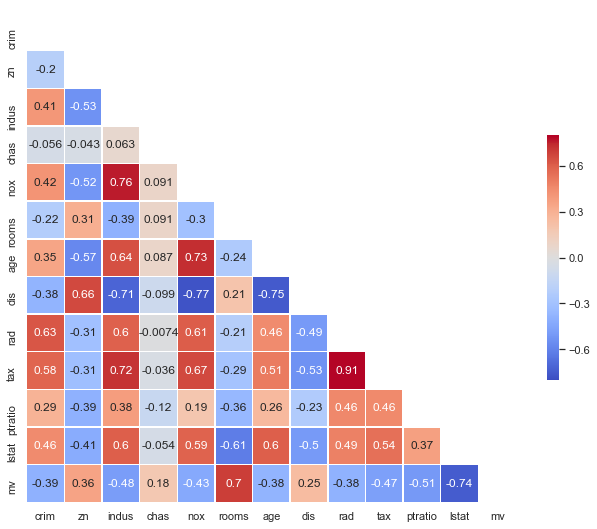

In [0]:
# Seaborn style
sns.set(style="white")

# Correlation matrix
corr = boston.corr()

# Mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Heatmap with mask
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmin=-.8, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

From the correlation matrix, I can see that the number of rooms positively correlates with the median value, while a property's lower status negatively correlates with the median value. Also of note are some variables that look to be multicollinear including poperty taxes, proximity to radial highways, amount of nitric oxide, proportion of non-residential units found in the area, and age of house. 

Next, i decided to look at a distribution plot for the median house value. As expected, the plot is slightly right-skewed. There also aprears to be a cap at 50,000 which creates a slight bi-modal shape.

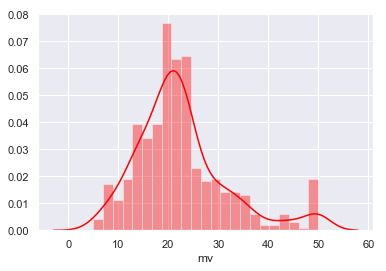

In [0]:
# Seaborn style
sns.set(style='darkgrid')

#Distribution plot for median value
sns.distplot(boston['mv'], color = 'red')

It's now time to scale the data. I chose to only scale the explanatory variables, and not the response variable so that the predictions would be in a scale that would be easily interpretable. I chose to use the standard scaler that appeared in the jump-start code. 

In [0]:
# Setting scaler
scaler = StandardScaler()

# Creating dataframes for the explanatory variables and response variable
X = boston.drop(['mv'], axis=1)
y = boston['mv']

# Scaling the explanatory variables
X_scaled = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)

print('-' * 50)
print('\nScaled Data')
display(X_scaled.head())
print('-' * 50)
print('\nResponse Variable')
display(y.head())

# Maximum and Minimum of Median Home Prices
print('-' * 50)
print('\nMaximum and Minimum of Median Home Prices')
print(min(y))
print(max(y))

--------------------------------------------------

Scaled Data


,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,-1.075562
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,-0.492439
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,-1.208727
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,-1.361517
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,-1.026501


--------------------------------------------------

Response Variable


0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: mv, dtype: float64

--------------------------------------------------

Maximum and Minimum of Median Home Prices
5.0
50.0


# Linear Regression

During my research and reading, I saw that using learning curves can help determine how much bias and variance will be in the model and also help determine an appropriate training set size. I used cross-validation with 10 folds, then calculated the mean for the training and validation scores, and finally plotted the results.

In [0]:
# Training set sizes
train_sizes = [1, 50, 100, 150, 200, 250, 300, 350, 400, 455]

# Learning curve for linear regression with 10-fold cross-validation
train_sizes, train_scores, validation_scores = learning_curve(
                                                   estimator = LinearRegression(), X = X_scaled,
                                                   y = y, train_sizes = train_sizes, cv = 10,
                                                   scoring = 'neg_mean_squared_error')
# Means for training scores and validation scores
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

(0, 150)

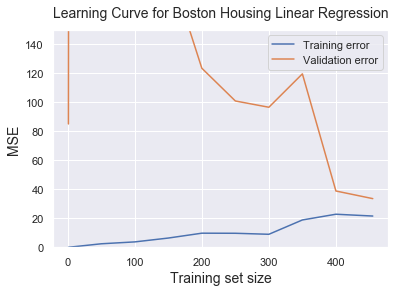

In [0]:
# Seaborn style
sns.set(style='darkgrid')

# Plot of training and validation scores
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

# Plot labeling
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning Curve for Boston Housing Linear Regression', fontsize = 14, y = 1.03)
plt.legend()
plt.ylim(0,150)

This plot shows that the training and validations sets don't really start to converge until there are at least 400 instances in the training set. The RMSE is hovering around $4.5K which seems high and there is a big gap between the lines, which indicates that the model suffers from both high bias as well as high variance. Since we cannot add more instaces or more features, a more complex model would probably do a better job. 

Moving forward with the linear regession, I decided on an 80/20 split for the data since that will create a training set of 404 instances

In [0]:
# Creating an 80/20 training/testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = RANDOM_SEED)

# Checking training set and testing set sizes
print('-' * 50)
print('Explanatory Variables Training Shape: {}'.format(X_train.shape))
print('\nResponse Variable Training Shape: {}'.format(y_train.shape))
print('-' * 50)
print('Explanatory Variables Test Shape: {}'.format(X_test.shape))
print('\nResponse Variable Test Shape: {}'.format(y_test.shape))


--------------------------------------------------
Explanatory Variables Training Shape: (404, 12)

Response Variable Training Shape: (404,)
--------------------------------------------------
Explanatory Variables Test Shape: (102, 12)

Response Variable Test Shape: (102,)


I used cross_val_score with 10 folds for the cross validation

In [0]:
# Making an object instance 
lin_reg = LinearRegression(fit_intercept = True)

# Training the model
boston_model = lin_reg.fit(X_train, y_train)
scores = cross_val_score(lin_reg, X_train, y_train, scoring = 'neg_mean_squared_error', cv = 10)
rmse_scores = np.sqrt(-scores)

#Printing RMSE Scores, Coefficients, and Intercept
print('-' * 50)
print('RMSE Scores for Cross-Validation:\n')
for score in rmse_scores:
    print(score)
print('-' * 50)
print('Coefficients:\n')    
for coef in boston_model.coef_:
    print(coef)

print('-' * 50)
print('Intercept:\n') 
print(boston_model.intercept_)

--------------------------------------------------
RMSE Scores for Cross-Validation:

3.5333445324315287
4.951299254108352
5.827651315797572
4.257321840177646
4.566392901515548
3.9907739728292877
5.8093630291775264
5.85910614233728
5.7228084493886575
3.5208851038687
--------------------------------------------------
Coefficients:

-0.11755541273046474
0.06017008529154487
0.015369680387025953
2.244581300576328
-20.278077456961967
2.982644795756847
0.0061357093372219305
-1.5510134167549678
0.28556877123098695
-0.011808106721756376
-0.9345333309820326
-0.5718108370745947
--------------------------------------------------
Intercept:

46.54027873061543


The RMSE scores for the cross-validation again seem very high, with errors ranging from 3.5 thousand to 5.8 thousand. Also, the Nitric Oxide coefficent shows that as the median house price increases, the amount of nitric oxide decreases by a high magnitude.

I next looked at the test set and created predictions to see how well the model would generalize.

Text(0, 0.5, 'Predictions')

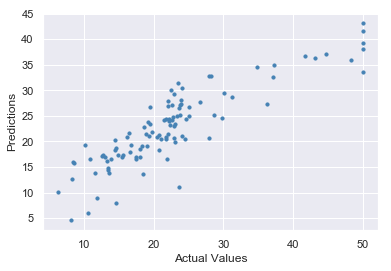

In [0]:
# Predicting from X_test data
predict = boston_model.predict(X_test)

# Plotting predicted vs actual values
plt.scatter(y_test, predict, c='steelblue', s=10)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')

It looks like there is quite a bit of variance between the predicted an actual values. I would expect to see more of a straight line if the predictions were more accurate.

In [0]:
# Printing RMSE and R^2 Scores
print('-' * 50)
print('RSME for y_test vs predicted values')
print(sqrt(mean_squared_error(y_test, predict)))
print('-' * 50)
print('R^2 for y_test vs predicted values')
print(r2_score(y_test, predict))

--------------------------------------------------
RSME for y_test vs predicted values
4.950529815346268
--------------------------------------------------
R^2 for y_test vs predicted values
0.7520146430543377


Again, the RSME is high, but the R^2 is .75, which is isn't a bad score provided the residual plots look good. I plotted those next.

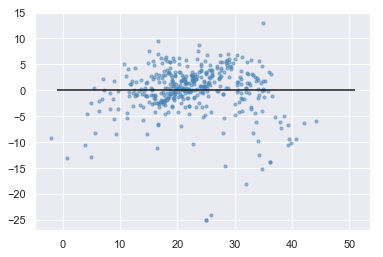

In [0]:
# Residual plot of training data
plt.scatter(boston_model.predict(X_train), boston_model.predict(X_train) - y_train, color = 'steelblue', s = 10, alpha = .5)
plt.hlines(0,-1,51)

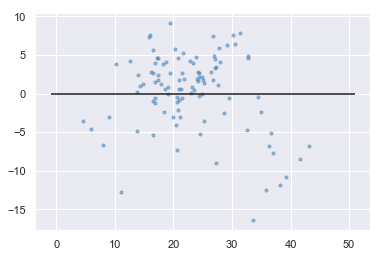

In [0]:
# Residual plot of testing data
plt.scatter(boston_model.predict(X_test), boston_model.predict(X_test) - y_test, color = 'steelblue', s =10, alpha = .5)
plt.hlines(0,-1,51)

The residual plots appear fairly random, but there are more point clustered above 0 than below, indicating a Y-axis imbalance. There is also a diagonal line which proabably means that there is a explanatory variable that is directly correlated with the response variable. Some additional EDA could help with this.

# Ridge Regression

I decided to try ridge regression next, since it is supposed to be good for data with multicollinearity, which this data appears to have. I started with a learning curve to see how it compared to the linear regression model. Again I used 10-fold cross-validation.

In [0]:
# Calculating training and validation scores
train_sizes, train_scores, validation_scores = learning_curve(
                                                   estimator = Ridge(fit_intercept = True), X = X_scaled,
                                                   y = y, train_sizes = train_sizes, cv = 10,
                                                   scoring = 'neg_mean_squared_error')

# Training and Validation score means
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

(0, 100)

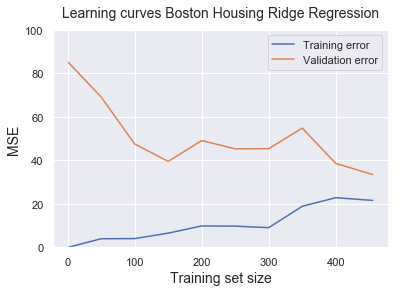

In [0]:
# Seaborn style

# Plotting training and validation errors
sns.set(style='darkgrid')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

# Labeling plot
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves Boston Housing Ridge Regression', fontsize = 14, y = 1.03)
plt.legend()
plt.ylim(0,100)

While it still appears that the model still has both high bias and high variance, the variance has decreased significantly as the validation error is much lower.

In [0]:
# Creating object instance of ridge regression
ridge_reg = Ridge(fit_intercept = True)

boston_model_ridge = ridge_reg.fit(X_train, y_train)
scores = cross_val_score(ridge_reg, X_train, y_train, scoring = 'neg_mean_squared_error', cv = 10)
rmse_scores = np.sqrt(-scores)

print('-' * 50)
print('RMSE Scores for Cross-Validation:\n')
for score in rmse_scores:
    print(score)
    
print('-' * 50)
print('Coefficients:\n')    
for coef in boston_model_ridge.coef_:
    print(coef)

print('-' * 50)
print('Intercept:\n') 
print(boston_model_ridge.intercept_)

--------------------------------------------------
RMSE Scores for Cross-Validation:

3.4058439514533636
4.971645104384911
5.930107743670047
4.325309526436382
4.659586431542625
3.9743123781614544
5.705599637870313
5.8630231167717834
5.80265895999025
3.588965356460653
--------------------------------------------------
Coefficients:

-0.11284714959827716
0.06078409870495245
-0.02518892636665695
2.0504773462348855
-11.236019446343414
3.0500271396930723
-0.0011993741250860405
-1.4172973671600078
0.2640864066984945
-0.012692657719025308
-0.8312470227281433
-0.5842655105961462
--------------------------------------------------
Intercept:

40.359097108315915


The RMSE scores are similar to that of the linear regression, but the coefficient magnitude has decreased.

Next I had the model make predictions for the test set and compared it to the actual values.

Text(0, 0.5, 'Predictions')

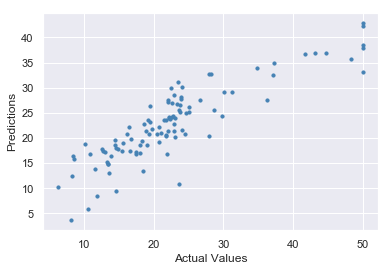

In [0]:
# Making predictions using test set
predict_ridge = boston_model_ridge.predict(X_test)

# Plotting Predictions vs Actual Values
plt.scatter(y_test, predict_ridge, c='steelblue', s=10)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')

This plot still looks very similar to the linear regression. I looked at the RMSE and R^2 scores to see if there was any improvement from the linear regression model.

In [0]:
# Printing RMSE and R^2 Scores
print('-' * 50)
print('RSME for y_test vs predicted values')
print(sqrt(mean_squared_error(y_test, predict_ridge)))
print('-' * 50)
print('R^2 for y_test vs predicted values')
print(r2_score(y_test, predict_ridge))

--------------------------------------------------
RSME for y_test vs predicted values
4.93579010650017
--------------------------------------------------
R^2 for y_test vs predicted values
0.7534891480270521


There is no difference between the linear regression and ridge regression.I expect the residual plot to also look the same.

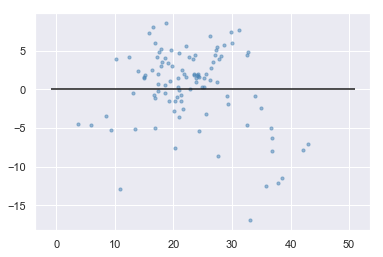

In [0]:
# Residual plot for ridge regression
plt.scatter(boston_model_ridge.predict(X_test), boston_model_ridge.predict(X_test) - y_test, color = 'steelblue', s =10, alpha = .5)
plt.hlines(0,-1,51)

Again there appears to be a Y-imbalance as well a explanatory variable that is directly correlated with the response variable (which makes sense since I have not removed any variables).

The benefit of ridge regression is that the alpha parameter can be adjusted to achieve a better model. I wanted to find the best alpha for this model.

In [0]:
# Storing RidgeCV as an object instance - 10 fold CV
ridge_cv = RidgeCV(alphas=[.0001, .001, .01, 0.1, 1.0, 10.0], cv=10)
boston_model_cv = ridge_cv.fit(X_train, y_train)
boston_model_cv.alpha_

0.1

In [0]:
ridge_cv = RidgeCV(alphas=[0.05, .1, .15], cv=10)
boston_model_cv = ridge_cv.fit(X_train, y_train)
boston_model_cv.alpha_

0.05

In [0]:
ridge_cv = RidgeCV(alphas=[0.02, .03, .04, .05, .06, .07, .08, .09], cv=10)
boston_model_cv = ridge_cv.fit(X_train, y_train)
boston_model_cv.alpha_

0.07

Since .07 is a better alpha, I wanted to see if this would improve the model.

In [0]:
ridge_reg2 = Ridge(fit_intercept = True, alpha = .07)

boston_model_ridge2 = ridge_reg2.fit(X_train, y_train)
scores = cross_val_score(ridge_reg2, X_train, y_train, scoring = 'neg_mean_squared_error', cv = 10)
rmse_scores2 = np.sqrt(-scores)

print('-' * 50)
print('RMSE Scores for Cross-Validation:\n')
for score in rmse_scores2:
    print(score)
    
print('-' * 50)
print('Coefficients:\n')    
for coef in boston_model_ridge2.coef_:
    print(coef)

print('-' * 50)
print('Intercept:\n') 
print(boston_model_ridge2.intercept_)

--------------------------------------------------
RMSE Scores for Cross-Validation:

3.5132064171741284
4.953025350531747
5.838772171934325
4.261239026935747
4.573851772204191
3.986949785884568
5.79247935369917
5.852700692493799
5.730261486677394
3.524586396789518
--------------------------------------------------
Coefficients:

-0.11698720318070573
0.06023684649926799
0.010510215765141447
2.2244898169005225
-19.197361682323375
2.9921325230649405
0.005244048453391756
-1.5350592350116485
0.2829365483396161
-0.011911124401051144
-0.9220720886356413
-0.573192514475266
--------------------------------------------------
Intercept:

45.78958103688795


Text(0, 0.5, 'Predictions')

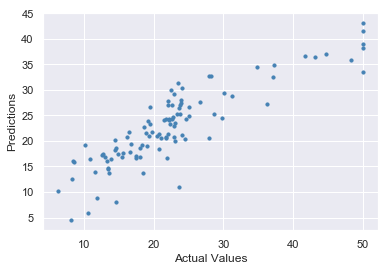

In [0]:
# Predicting values for testing set
predict_ridge2 = boston_model_ridge2.predict(X_test)

# Plotting actual vs predicted values
plt.scatter(y_test, predict_ridge2, c='steelblue', s=10)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')

In [0]:
# Printing RMSE and R^2 Scores
print('-' * 50)
print('RSME for y_test vs predicted values')
print(sqrt(mean_squared_error(y_test, predict_ridge2)))
print('-' * 50)
print('R^2 for y_test vs predicted values')
print(r2_score(y_test, predict_ridge2))

--------------------------------------------------
RSME for y_test vs predicted values
4.945702150002294
--------------------------------------------------
R^2 for y_test vs predicted values
0.7524980687155172


It actually seems like the model is a little worse.

With the small amount of data in this set, there isn't really any difference between the two models. They both appear to underfit the data.

For fun, I decided to see if removing some variables would result in a better model. I read that the VIF (Variance Inflation Factor) measure could help find the variables that are multicollinear.

In [0]:
# Fix for statsmodels module
import sys
sys.path.append('c:/users/mturn/anaconda3/lib/site-packages')

# Calculating VIF for explanatory variables.
from statsmodels.stats.outliers_influence import variance_inflation_factor
X2 = X.assign(const=1)
pd.Series([variance_inflation_factor(X2.values, i) 
               for i in range(X2.shape[1])], 
              index=X2.columns)

crim         1.767486
zn           2.298459
indus        3.987181
chas         1.071168
nox          4.369093
rooms        1.912532
age          3.088232
dis          3.954037
rad          7.445301
tax          9.002158
ptratio      1.797060
lstat        2.870777
const      535.526619
dtype: float64

I wanted to see how the learning curve for a ridge regression would be affected by dropping the explanatory variables with the highest VIFs.

In [0]:
# New dataframes for each data set to test
X_ml = boston_input.drop(['mv'], axis=1)
y = boston_input['mv']
X_scaled_ml = pd.DataFrame(scaler.fit_transform(X_ml),columns = X_ml.columns)

X_ml1 = boston_input.drop(['mv', 'tax'], axis=1)
X_scaled_ml1 = pd.DataFrame(scaler.fit_transform(X_ml1),columns = X_ml1.columns)

X_ml2 = boston_input.drop(['mv','tax', 'rad'], axis=1)
X_scaled_ml2 = pd.DataFrame(scaler.fit_transform(X_ml2),columns = X_ml2.columns)

X_ml3 = boston_input.drop(['mv','tax', 'rad', 'nox'], axis=1)
X_scaled_ml3 = pd.DataFrame(scaler.fit_transform(X_ml3),columns = X_ml3.columns)

X_ml4 = boston_input.drop(['mv','tax', 'rad', 'nox', 'indus'], axis=1)
X_scaled_ml4 = pd.DataFrame(scaler.fit_transform(X_ml4),columns = X_ml4.columns)

X_ml5 = boston_input.drop(['mv','tax', 'rad', 'nox', 'indus', 'dis'], axis=1)
X_scaled_ml5 = pd.DataFrame(scaler.fit_transform(X_ml5),columns = X_ml5.columns)

In [0]:
# Creating testing and validation error info for each dataframe

train_sizes, train_scores, validation_scores = learning_curve(
                                                   estimator = Ridge(fit_intercept=True), X = X_scaled_ml,
                                                   y = y, train_sizes = train_sizes, cv = 10,
                                                   scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

train_sizes, train_scores1, validation_scores1 = learning_curve(
                                                   estimator = Ridge(fit_intercept=True), X = X_scaled_ml1,
                                                   y = y, train_sizes = train_sizes, cv = 10,
                                                   scoring = 'neg_mean_squared_error')

train_scores_mean1 = -train_scores1.mean(axis = 1)
validation_scores_mean1 = -validation_scores1.mean(axis = 1)

train_sizes, train_scores2, validation_scores2 = learning_curve(
                                                   estimator = Ridge(fit_intercept=True), X = X_scaled_ml2,
                                                   y = y, train_sizes = train_sizes, cv = 10,
                                                   scoring = 'neg_mean_squared_error')

train_scores_mean2 = -train_scores2.mean(axis = 1)
validation_scores_mean2 = -validation_scores2.mean(axis = 1)

train_sizes, train_scores3, validation_scores3 = learning_curve(
                                                   estimator = Ridge(fit_intercept=True), X = X_scaled_ml3,
                                                   y = y, train_sizes = train_sizes, cv = 10,
                                                   scoring = 'neg_mean_squared_error')

train_scores_mean3 = -train_scores3.mean(axis = 1)
validation_scores_mean3 = -validation_scores3.mean(axis = 1)

train_sizes, train_scores4, validation_scores4 = learning_curve(
                                                   estimator = Ridge(fit_intercept=True), X = X_scaled_ml4,
                                                   y = y, train_sizes = train_sizes, cv = 10,
                                                   scoring = 'neg_mean_squared_error')

train_scores_mean4 = -train_scores4.mean(axis = 1)
validation_scores_mean4 = -validation_scores4.mean(axis = 1)

train_sizes, train_scores5, validation_scores5 = learning_curve(
                                                   estimator = Ridge(fit_intercept=True), X = X_scaled_ml5,
                                                   y = y, train_sizes = train_sizes, cv = 10,
                                                   scoring = 'neg_mean_squared_error')

train_scores_mean5 = -train_scores5.mean(axis = 1)
validation_scores_mean5 = -validation_scores5.mean(axis = 1)

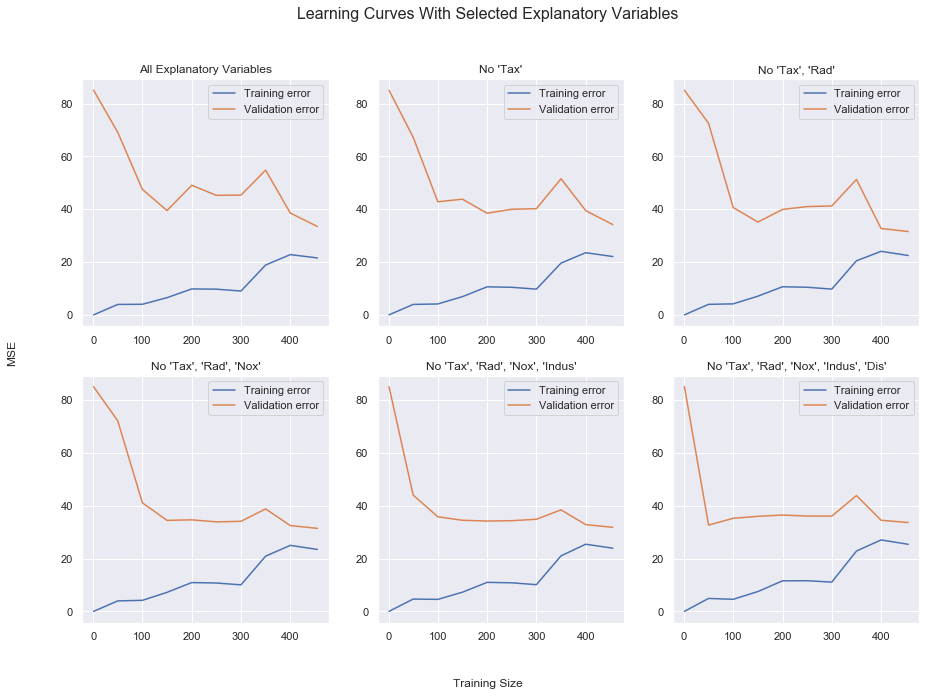

In [0]:
#Plotting learning curves
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
                                    ncols=3,
                                    nrows=2,
                                    figsize=(15, 10))

sns.set(style='darkgrid')
fig.suptitle('Learning Curves With Selected Explanatory Variables', fontsize=16)
fig.text(0.5, 0.04, 'Training Size', ha='center', va='center')
fig.text(0.06, 0.5, 'MSE', ha='center', va='center', rotation='vertical')

ax1.plot(train_sizes, train_scores_mean, label = 'Training error')
ax1.plot(train_sizes, validation_scores_mean, label = 'Validation error')
ax1.set_title('All Explanatory Variables')
ax1.legend(loc = 'upper right')

ax2.plot(train_sizes1, train_scores_mean1, label = 'Training error')
ax2.plot(train_sizes1, validation_scores_mean1, label = 'Validation error')
ax2.set_title('No \'Tax\'')
ax2.legend(loc = 'upper right')

ax3.plot(train_sizes2, train_scores_mean2, label = 'Training error')
ax3.plot(train_sizes2, validation_scores_mean2, label = 'Validation error')
ax3.set_title('No \'Tax\', \'Rad\'')
ax3.legend(loc = 'upper right')

ax4.plot(train_sizes3, train_scores_mean3, label = 'Training error')
ax4.plot(train_sizes3, validation_scores_mean3, label = 'Validation error')
ax4.set_title('No \'Tax\', \'Rad\', \'Nox\'')
ax4.legend(loc = 'upper right')

ax5.plot(train_sizes4, train_scores_mean4, label = 'Training error')
ax5.plot(train_sizes4, validation_scores_mean4, label = 'Validation error')
ax5.set_title('No \'Tax\', \'Rad\', \'Nox\', \'Indus\'')
ax5.legend(loc = 'upper right')

ax6.plot(train_sizes5, train_scores_mean5, label = 'Training error')
ax6.plot(train_sizes5, validation_scores_mean5, label = 'Validation error')
ax6.set_title('No \'Tax\', \'Rad\', \'Nox\', \'Indus\', \'Dis\'')
ax6.legend(loc = 'upper right')

Removing the property tax, proximity to a radial highway, and nitric oxide columns would result in the best model for this set.

# Conclusion

Running the linear regression and ridge regression models for this data set resulted in almost exact results. The models both appear to be underfitting the data, so the company could make a few choices to help make a better model.

1. If more instances were possible, the models may improve with more data

2. Removing variables that are prefectly correlated with the dependent variable and removing multicollinear variables could improve the models.

3. Choosing a more complex model that provides a better fir for the data.